In [4]:
import re
import numpy as np
import pandas as pd
from datetime import date, datetime
from calendar import monthrange
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)
from DataProcessing import *
from RevenueReportHelpers import *

# Guesty bookiing records
# Exclusions + rename Ocean Spray 3 -> Cottage 3
data = import_data()
excl = {"Bellevue 4551","Bothell 21833","NorthBend 44406","Ashford 137","Auburn 29123","Hoquiam 21"}
data = data[~data["Listing"].isin(excl)].copy()
data = data[~((data["booking_source"]=="owner")|(data["accommodation_fare"]==0))].copy()
data.loc[data["Listing"].eq("Seattle 3617 Origin"), "Listing"] = "Seattle 3617"
data.loc[data["Listing"].eq("Seattle 906"), "Listing"] = "Seattle 906 Lower"
occupancy, daily = cal_occupancy(data)
owner_payout, OwnerPayout = build_owner_payout(endmonth=12)
property = property_input()


In [5]:
### ADR Range report
mask =(data["total_revenue"]==48.5)&(data["yearmonth"].isin(["2024-10","2024-11"]))|\
    (data["Confirmation.Code"].isin(["HMBE2E392M","HMQAWPFBSZ","HM5ZZBP4NK"]))
 # remove testing rent)].copy()

data_adr = data[(~mask) & (data["checkin_date"]>=pd.to_datetime('2024-01-01'))& (data["checkin_date"]<=pd.to_datetime('2025-12-31'))].\
    merge(property[["Listing","Set","Type","Status"]],on="Listing",how="left")
rangeADR = (data_adr
            .groupby(["Listing"],as_index=False)
            .agg(minADR=("AvgDailyRate","min"),
                 maxADR=("AvgDailyRate","max"),
                 avgADR=("AvgDailyRate","mean"),
                 medADR=("AvgDailyRate","median"),
                 bookings =("Confirmation.Code","nunique"),
                 start_date=("checkin_date","min"),
                 endd_ate=("checkout_date","max")))

rangeADR["start_date"] = rangeADR["start_date"].astype(str).str[:10]
rangeADR["end_date"] = rangeADR["endd_ate"].astype(str).str[:10]
rangeADR = safe_round(rangeADR, ndigits=2)

rangeADR_Set = (data_adr
                .groupby(["Set"],as_index=False)
                .agg(minADR=("AvgDailyRate","min"),
                     ADR005=("AvgDailyRate",lambda x: x.quantile(0.005)),
                     ADR025=("AvgDailyRate",lambda x: x.quantile(0.025)),
                     ADR16=("AvgDailyRate",lambda x: x.quantile(0.16)),
                     medADR=("AvgDailyRate","median"),
                     ADR84=("AvgDailyRate",lambda x: x.quantile(0.84)),
                     ADR90=("AvgDailyRate",lambda x: x.quantile(0.90)),
                     ADR95=("AvgDailyRate",lambda x: x.quantile(0.95)),
                     maxADR=("AvgDailyRate","max")))
rangeADR_Set = safe_round(rangeADR_Set, ndigits=2)

Ranges = (property[["Listing","Type","Status","BEDROOMS","Set"]]
          .merge(rangeADR,on="Listing",how="right")
          .merge(rangeADR_Set,on="Set",how="left",suffixes=("_Listing","_Set")))

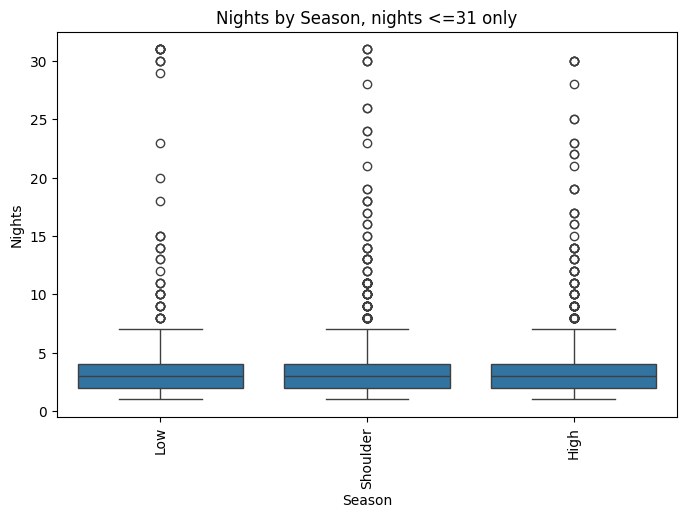

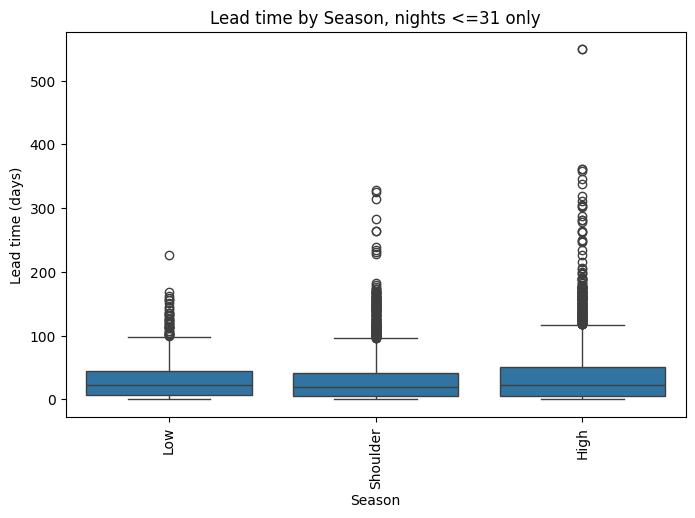

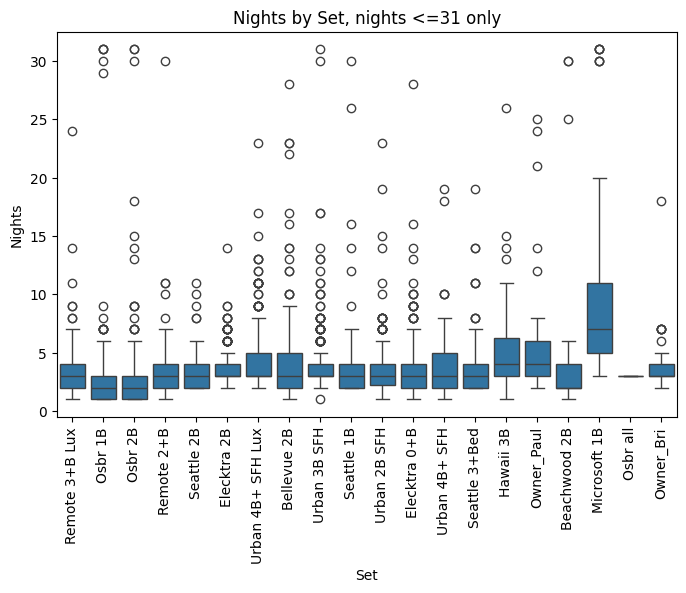

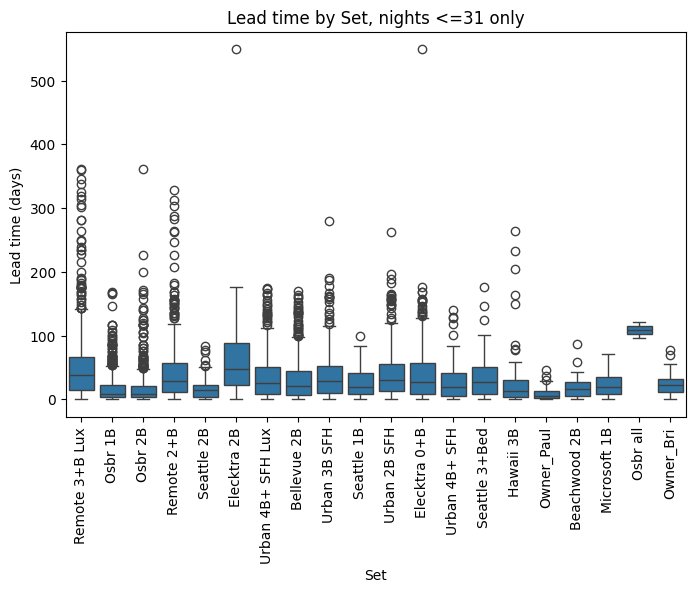

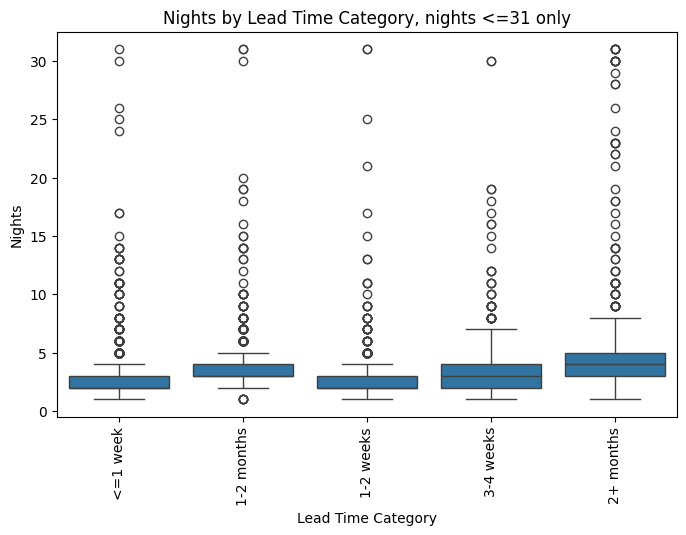

In [6]:
## length of stay report and lead time report
data_str = data_adr.loc[(data_adr["Status"]=="Active") & (data_adr["Type"]=="STR") & (data_adr["nights"]<=31)].copy()
data_str["Year"]=data_str["checkin_date"].dt.strftime("%Y")
data_str["Month"]=data_str["checkin_date"].dt.strftime("%m")
data_str["Season"]=np.where(data_str["Month"].isin(["01","02","03"]),"Low",
                    np.where(data_str["Month"].isin(["04","05","10","11","12"]),"Shoulder","High"))
data_str["LeadTimeCategory"] = np.where(data_str["lead_time"]<=7,"<=1 week",
                                        np.where(data_str["lead_time"]<=14,"1-2 weeks",
                                 np.where(data_str["lead_time"]<=30,"3-4 weeks",
                        np.where(data_str["lead_time"]<60,"1-2 months","2+ months"))))

rangeStay = (data_str 
             .groupby(["Listing"],as_index=False)
             .agg(minStay=("nights","min"),
                 maxStay=("nights","max"),
                 avgStay=("nights","mean"),
                 medStay=("nights","median"),
                 bookings =("Confirmation.Code","nunique"),
                 start_date=("checkin_date","min"),
                 endd_ate=("checkout_date","max")))
rangeStay = safe_round(rangeStay, ndigits=0)

rangeStay_Set = (data_str 
                 .groupby(["Set"],as_index=False)
                 .agg(minStay=("nights","min"),
                     Stay05=("nights",lambda x: x.quantile(0.05)),
                     Stay10=("nights",lambda x: x.quantile(0.10)),
                     Stay16=("nights",lambda x: x.quantile(0.16)),
                     medStay=("nights","median"),
                     Stay84=("nights",lambda x: x.quantile(0.84)),
                     Stay90=("nights",lambda x: x.quantile(0.90)),
                     Stay95=("nights",lambda x: x.quantile(0.95)),
                     maxStay=("nights","max")))
rangeStay_Set = safe_round(rangeStay_Set, ndigits=0)

rangeStay_Set

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Season", y="nights")
plt.title("Nights by Season, nights <=31 only")
plt.xlabel("Season")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Season", y="lead_time")
plt.title("Lead time by Season, nights <=31 only")
plt.xlabel("Season")
plt.xticks(rotation=90)
plt.ylabel("Lead time (days)")
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Set", y="nights")
plt.title("Nights by Set, nights <=31 only")
plt.xlabel("Set")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Set", y="lead_time")
plt.title("Lead time by Set, nights <=31 only")
plt.xlabel("Set")
plt.xticks(rotation=90)
plt.ylabel("Lead time (days)")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="LeadTimeCategory", y="nights")
plt.title("Nights by Lead Time Category, nights <=31 only")
plt.xlabel("Lead Time Category")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

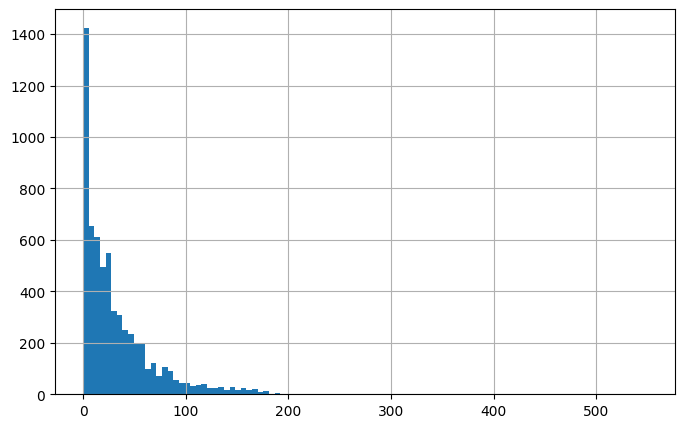

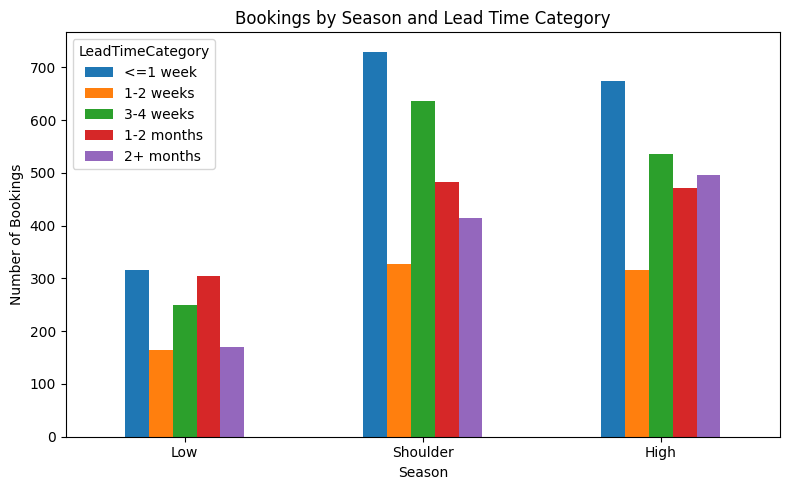

In [7]:
## Lead time related
#data_str['nights'].hist(bins=31, figsize=(8, 5))

data_str["lead_time"].hist(bins=100, figsize=(8, 5))
data_str["nights"].describe()
data_str["lead_time"].describe()

#data_str.loc[data_str["lead_time"]<=1,["Listing","Confirmation.Code","checkin_date","confirmation_date","lead_time"]]

data_str.groupby(["LeadTimeCategory"]).size()

leadtime_order = [
    "<=1 week",
    "1-2 weeks",
    "3-4 weeks",
    "1-2 months",
    "2+ months"
]
season_order = ["Low","Shoulder","High"]
ct=data_str.groupby(["LeadTimeCategory","Season"]).size().unstack(fill_value=0)
ct = ct.reindex(leadtime_order)
ct = ct.reindex(columns=season_order)
ax = ct.T.plot(
    kind="bar",
    figsize=(8, 5)
)

ax.set_xlabel("Season")
ax.set_ylabel("Number of Bookings")
ax.set_title("Bookings by Season and Lead Time Category")

plt.xticks(rotation=0)
plt.legend(title="LeadTimeCategory")
plt.tight_layout()
plt.show()

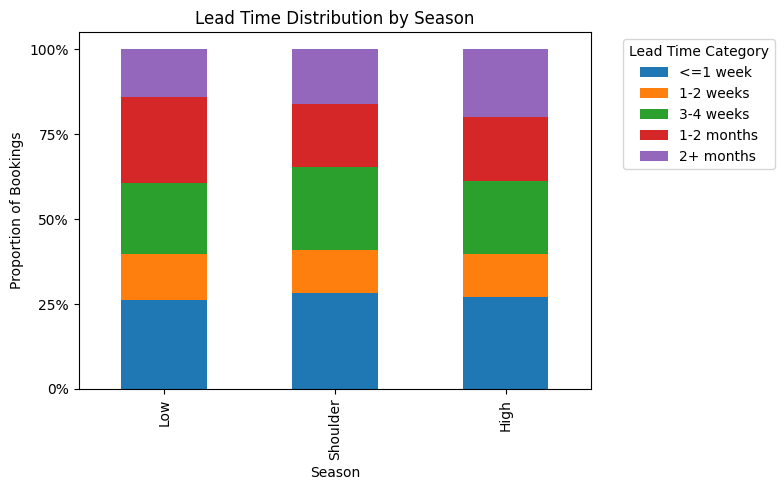

In [8]:
ct_prop = ct.div(ct.sum(axis=0), axis=1)
ax = ct_prop.T.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

ax.set_xlabel("Season")
ax.set_ylabel("Proportion of Bookings")
ax.set_title("Lead Time Distribution by Season")

# Optional: show percentages on y-axis
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])

plt.legend(title="Lead Time Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()